In [1]:
import numpy as np
import pandas as pd

### Snippet 2.1 The Marcenko-Pastur PDF

In [2]:
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N
    eMin = var * (1 - (1.0 / q) ** 0.5) ** 2
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    eVal = np.linspace(eMin, eMax, pts)
    
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    
    if len(pdf.shape) > 1 :
        pdf = pdf.squeeze()
    
    pdf = pd.Series(pdf, index = eVal)
    
    return pdf

### Snippet 2.2 Testing the Marcdnko-Pastur Theorem

In [6]:
from sklearn.neighbors.kde import KernelDensity

def getPCA(matrix) :
    
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc
    
    eVal = eVal[indices]
    eVec = eVec[:, indices]
    
    eVal = np.diagflat(eVal)
    
    return eVal, eVec

def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x=None) :
    # Fit kernel to a series of obs, and derive the probability of obs
    # x : the array of values on which the fit KDE will be evaluated
    
    if len(obs.shape) == 1 :
        obs = obs.reshape(-1,1)
        
    if x is None :
        x = np.unique(obs).reshape(-1, 1)
        
    if len(x.shape) == 1 :
        x = x.reshape(-1, 1)
        
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    
    logProb = kde.score_samples(x) #log(density)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    
    return pdf


x = np.random.normal(size = (10000,1000))


eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

# Marcenko-Pastur pdf
pdf0 = mpPDF(1.0, q = x.shape[0]/float(x.shape[1]), pts = 1000)

# Empricial PDF
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)
    

### Plot Figure 2.1

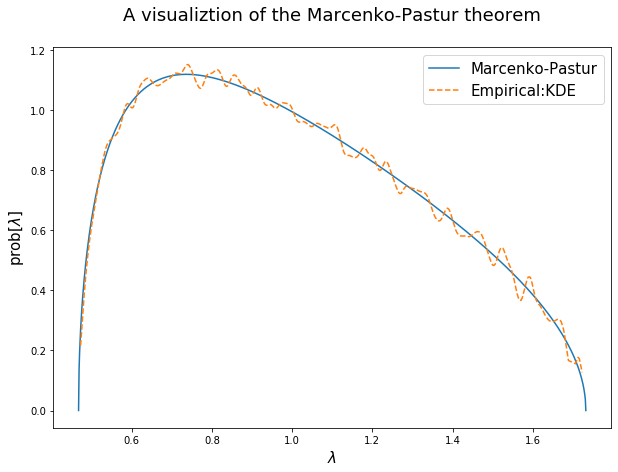

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(pdf0, label = "Marcenko-Pastur")
ax.plot(pdf1, '--',label = "Empirical:KDE")

ax.set_title('A visualiztion of the Marcenko-Pastur theorem\n', fontsize = 18)
ax.set_ylabel('prob[$\lambda$]', fontsize = 15)
ax.set_xlabel('$\lambda$', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.3 Add signal to a random covariance matrix

In [9]:
def getRndCov(nCOls, nFacts) :
    
    w = np.random.normal( size = (nCols, nFacts))
    
    # Random cov matrix, however not full rank
    cov = np.dot(w, w.T)
    
    # Make full rank cov
    cov += np.diag(np.random.uniform(size=nCols)) 
    
    return cov

def cov2corr(cov) :
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std,std)
    
    # Clipping to prevent numerical errors
    corr[corr <-1] = -1
    corr[corr > 1] = 1
    
    return corr



#### Practice

In [10]:
alpha = 0.995
nCols = 1000
nFact = 100
q = 10

cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar = 0)

# make noise + signal covariance matrix (weights = alpha)
cov = alpha * cov + (1-alpha) * getRndCov(nCols, nFact)

corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

### Snippet 2.4 Fitting the Marcenko-Pastur PDF

In [11]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts = 1000) :
    # Fit error
    # Theoretical pdf
    
    # var 가 list에 묶여져 오는 경우를 방지
    if hasattr(var, "__len__") :
        if len(var) == 1 :
            var = var[0]
        else :
            raise ValueErroral ("var  must be scalar")
    
    
    pdf0 = mpPDF(var, q, pts)
    # Empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    
    return sse


def findMaxEval(eVal, q, bWidth) :
    # Find Max random eVal by fitting Marcenko's distribution
    
    # Scipy.optimize.minimize
    # fun : Theobjective function to be minimized
    # x0 : ndarray, shape(n,), initial guess. array of real emlements of size
    
    out = minimize(fun = lambda *x : errPDFs(*x), x0 = .5, # first arg : var
                   args = (eVal, q, bWidth), bounds = ((1e-5, 1 - 1e-5),))
    
    if out['success'] :
        var = out['x'][0]
    else :
        var = 1
        
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    return eMax, var

#### Practice

In [12]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)

nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)


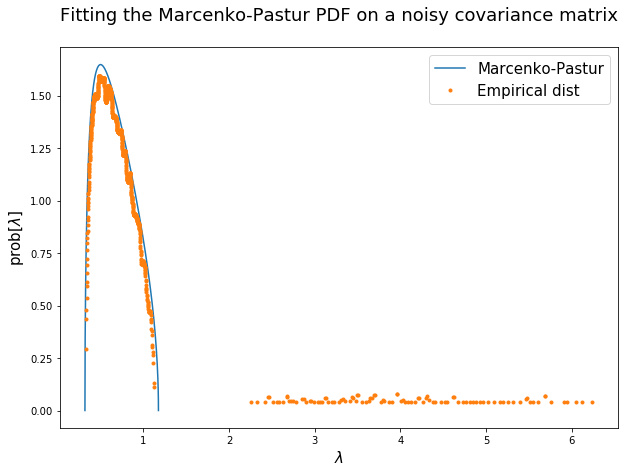

In [13]:
# make graphs

pdf0 = mpPDF(var0, q = q, pts = 1000)


# Empricial PDF
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)



fig, ax = plt.subplots(figsize=(10,7))


ax.plot(pdf0, label = "Marcenko-Pastur")
ax.plot(pdf1,label = "Empirical dist", marker=".", linestyle="")

ax.set_title('Fitting the Marcenko-Pastur PDF on a noisy covariance matrix\n', fontsize = 18)
ax.set_ylabel('prob[$\lambda$]', fontsize = 15)

ax.set_xlabel('$\lambda$', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.5 Denoising by constant residual eigenvalue

In [12]:
def denoisedCorr(eVal, eVec, nFacts):
    # Remove noise from corr by fixing randome eigenvalues
    
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    
    return corr1

#### Practice

In [13]:
# Denoised Corr
corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVac1 = getPCA(corr1)

# Original eigenvalue = eVal0


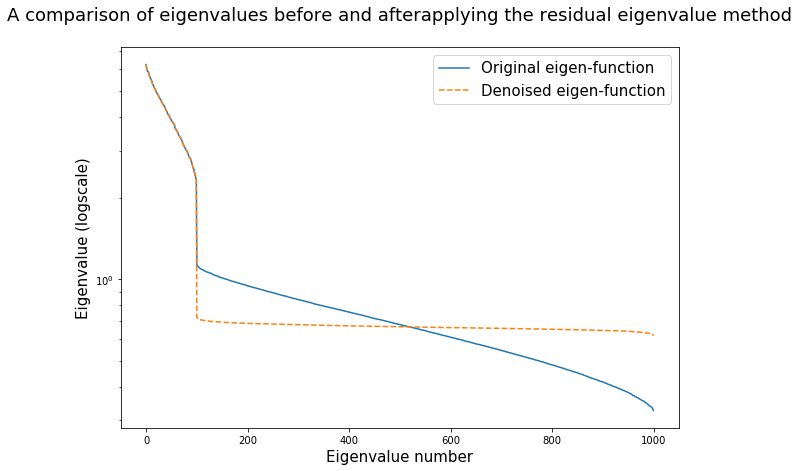

In [14]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and afterapplying the residual eigenvalue method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.6 Denoising by targeted shrinkage

In [14]:
def denoisedCorr2(eVal, eVec, nFacts, alpha = 0) :
    # Remove noisse from corr through targeted shrinkage
    
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:,:nFacts]
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:,nFacts:]
    
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)

    
    corr2 = corr0 + alpha * corr1 + (1-alpha) * np.diag(np.diag(corr1))
    
    return corr2

#### Practice

In [15]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.5)

eVal1, eVec = getPCA(corr1)

(1000, 1000) (1000, 1000)


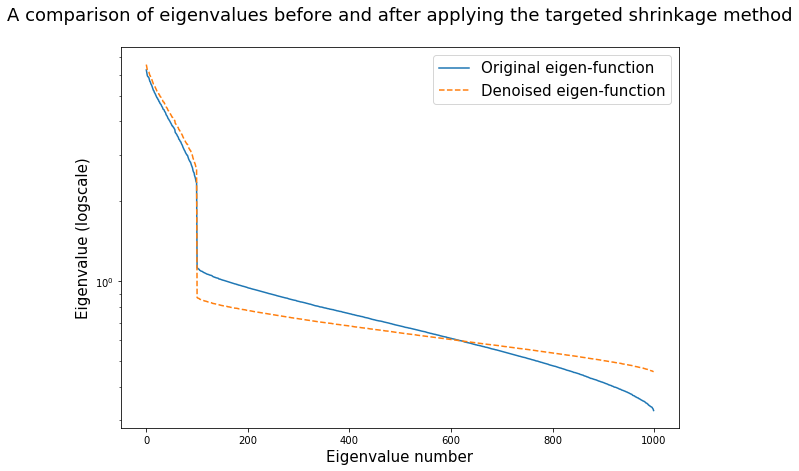

In [17]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

In [18]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.0)

eVal1, eVec = getPCA(corr1)

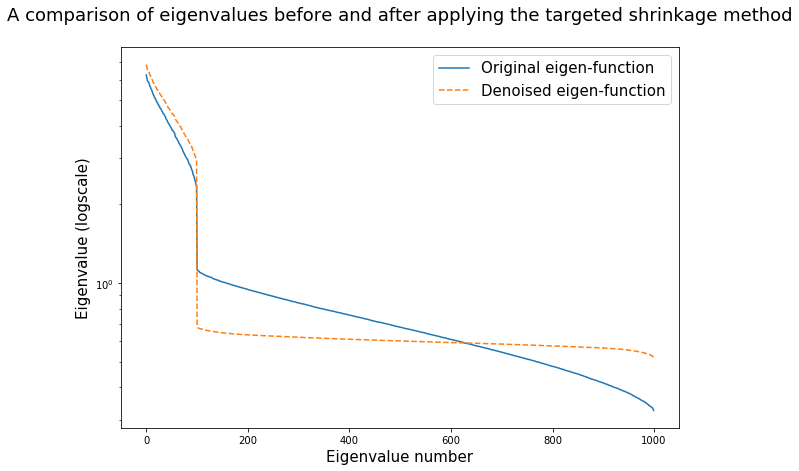

In [19]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

In [20]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 1.0)

eVal1, eVec = getPCA(corr1)

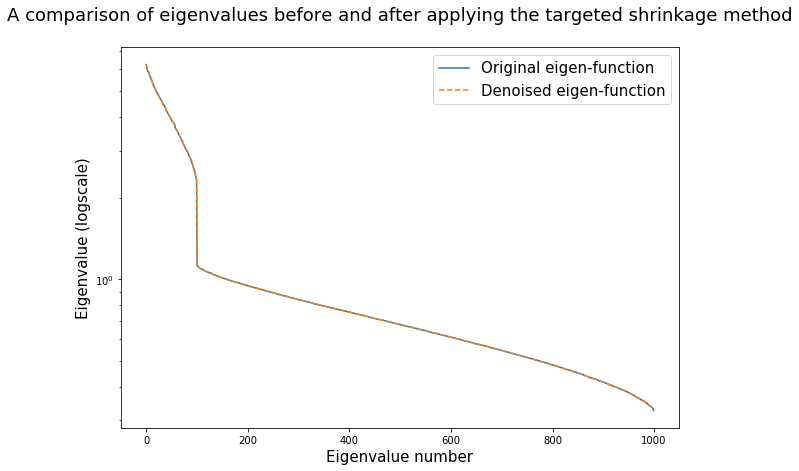

In [21]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)